In [1]:
%env THEANO_FLAGS='device=cuda', 'floatX=float32', 'gpuarray.preallocate=0.2'

env: THEANO_FLAGS='device=cuda', 'floatX=float32', 'gpuarray.preallocate=0.2'


In [2]:
from psgd.sampling import SimpleSampler
from psgd.grouping import greedy_pairing_labels, greedy_pairing

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from craynn.utils import mnist

from tqdm import tqdm_notebook

Using cuDNN version 7005 on context None
Preallocating 1622/8110 Mb (0.200000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


## Data

In [4]:
X_train, _, X_test, _ = mnist(cast='float32')

In [5]:
X_train /= 255.0
X_test /= 255.0

In [6]:
def get_rotated(X):
    indx = np.random.permutation(X.shape[0])
    n = X.shape[0]

    X_rot = X[indx[(n // 2):]]
    X_original = X[indx[:(n // 2)]]
    
    def rotate_data(X, angles):
        from skimage.transform import rotate

        if not hasattr(angles, 'shape'):
            angles = np.ones(X.shape[0]) * angles
        return np.array([
            rotate(X[i, 0], angle=angles[i], order=3, resize=False, preserve_range=True).reshape(1, 28, 28)
            for i in tqdm_notebook(range(X.shape[0]))
        ]).astype('float32')
    

    angles = np.random.normal(10, 5, size=X_rot.shape[0])
    X_rot = rotate_data(X_rot, angles)

    angles = np.random.normal(20, 5, size=X_original.shape[0])
    X_original = rotate_data(X_original, angles = angles)
    
    X = np.vstack([X_original, X_rot])
    y = np.hstack([
        np.ones(X_original.shape[0], dtype='float32'),
        np.zeros(X_rot.shape[0], dtype='float32')
    ])
    
    indx = np.random.permutation(X.shape[0])
    return X[indx], y[indx]

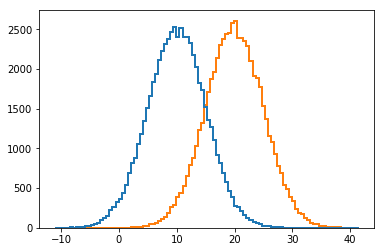

In [7]:
_ = plt.hist([
    np.random.normal(10, 5, size=X_train.shape[0]),
    np.random.normal(20, 5, size=X_train.shape[0]),
], bins=100, histtype='step', lw=2)

In [8]:
X_train, y_train = get_rotated(X_train)
X_test, y_test = get_rotated(X_test)

HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

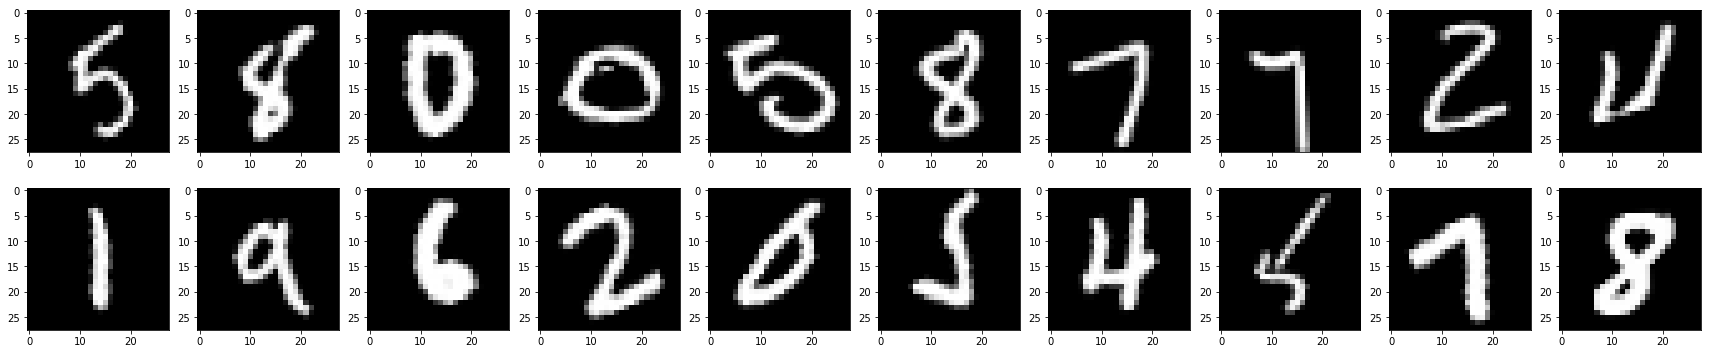

In [9]:
plt.subplots(nrows=2, ncols=10, figsize=(30, 6))

for j in range(10):
    plt.subplot(2, 10, j + 1)
    plt.imshow(X_train[2 * j, 0], cmap=plt.cm.Greys_r)

    plt.subplot(2, 10, j + 10 + 1)
    plt.imshow(X_train[2 * j + 1, 0], cmap=plt.cm.Greys_r)

## Network

In [10]:
import theano
import theano.tensor as T

from craynn.utils import mnist

from craynn.layers import *
from craynn.networks import *
from craynn.subnetworks import *
from craynn.updates import *
from craynn.utils import lsum
from craynn.viz import SNNWatcher, draw_to_notebook

In [11]:
n = 32

nn = net((None, 1, 28, 28))(
    conv(n, f=T.nnet.softplus), conv(n, f=T.nnet.softplus), max_pool(),
    conv(int(1.5 * n), f=T.nnet.softplus), conv(int(1.5 * n), f=T.nnet.softplus), max_pool(),
    conv(2 * n, f=T.nnet.softplus),
    dense(1, f = lambda x: x),
    flatten(outdim=1)
)

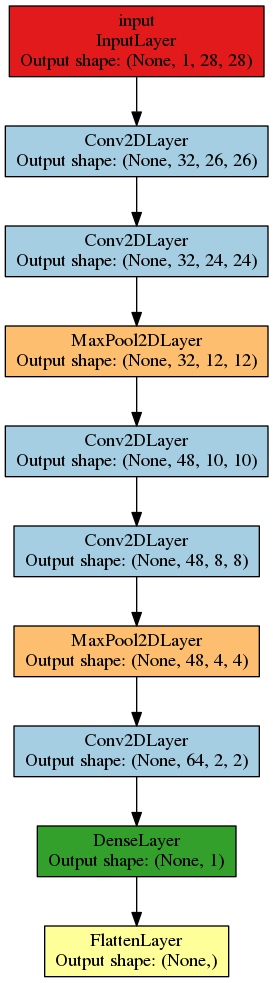

In [12]:
draw_to_notebook(nn)

In [13]:
print(nn.description())

Net
(None, 1, 28, 28) -> (None,)
total number of params: 72193
  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 32, 26, 26)
  number of params: 320
  output shape:(None, 32, 24, 24)
  number of params: 9248
  output shape:(None, 32, 12, 12)
  number of params: 0.0
  output shape:(None, 48, 10, 10)
  number of params: 13872
  output shape:(None, 48, 8, 8)
  number of params: 20784
  output shape:(None, 48, 4, 4)
  number of params: 0.0
  output shape:(None, 64, 2, 2)
  number of params: 27712
  output shape:(None, 1)
  number of params: 257
  output shape:(None,)
  number of params: 0.0


In [14]:
X = T.ftensor4()
y = T.fvector()

w = T.fvector()

In [15]:
f, = nn(X)

In [16]:
nn.reg_l2().eval()

array(177.2395, dtype=float32)

In [17]:
losses = y * T.nnet.softplus(-f) + (1 - y) * T.nnet.softplus(f)

pure_loss = T.mean(w * losses)
loss = pure_loss + 1.0e-3 * nn.reg_l2()

In [18]:
grad = theano.grad(T.sum(losses), nn.params())

grad_norm = T.sqrt(
    lsum([ T.sum(g ** 2) for g in grad ])
)

In [19]:
get_grad_norm = theano.function([X, y], grad_norm)

In [20]:
learning_rate = T.fscalar()

upd, rst = resetable.adam(loss, nn.params(), learning_rate=learning_rate)

train = theano.function(
    [X, y, w, learning_rate],
    [pure_loss, grad_norm],
    updates=upd, allow_input_downcast=True
)

reset = theano.function([], None, updates=rst)

In [21]:
predict = theano.function([X], T.nnet.sigmoid(f))

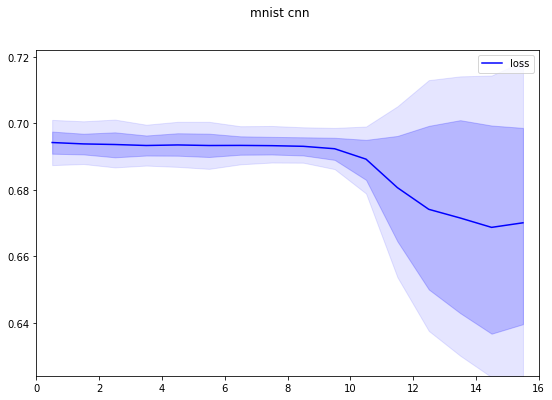

In [ ]:
watcher = SNNWatcher(title='mnist cnn', mode='fill')

num_epoches = 1024
num_batches = X_train.shape[0] // 32

losses = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
w = np.ones(shape=(X_train.shape[0], ), dtype='float32')

stream = streams.inf_random(X_train.shape[0], batch_size=32)

for i in range(num_epoches):
    for j in range(num_batches):
        indx = next(stream)
        losses[i, j], _ = train(X_train[indx], y_train[indx], w[indx], 1.0e-5)
    
    watcher.draw(losses[:(i + 1)])

In [ ]:
predict(X_train[:10]).shape

In [ ]:
np.sum([
    np.sum((predict(X_test[indx]) > 0.5) == y_test[indx])
    for indx in streams.seq(X_test.shape[0], batch_size=128)
]) / X_test.shape[0]